In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
excel_file = pd.read_excel('dataset_clean_Weather_jakarta_float_AD.xlsx')

In [3]:
df = pd.DataFrame(excel_file)
print(df)

         Tanggal    Tn    Tx  Tavg  RH_avg        RR   ss
0     01-01-2016  25.0  31.4  28.2    83.0  0.013787  4.0
1     02-01-2016  26.0  31.0  27.1    85.0  0.000000  3.0
2     03-01-2016  25.0  32.6  28.4    79.0  0.000000  2.0
3     04-01-2016  26.0  31.6  29.0    80.0  0.000000  3.6
4     05-01-2016  27.0  31.8  28.6    83.0  0.000000  3.0
...          ...   ...   ...   ...     ...       ...  ...
2534  09-12-2023  26.6  32.4  29.1    76.0  0.000000  3.6
2535  10-12-2023  26.8  32.0  29.2    77.0  0.000000  1.0
2536  11-12-2023  26.8  33.0  30.0    72.0  0.000000  0.0
2537  12-12-2023  28.0  33.2  30.8    69.0  0.000000  7.0
2538  13-12-2023  28.0  33.2  30.8    69.0  0.000000  7.0

[2539 rows x 7 columns]


In [4]:
import numpy as np

def konversi_variabel_laju(variabel):
    jumlah_data = len(variabel)
    laju = np.zeros(jumlah_data)

    for i in range(jumlah_data):
        if i == 0:
            laju[i] = variabel[i+1] - variabel[i]
        elif 0 < i < jumlah_data - 1:
            laju[i] = ((variabel[i] - variabel[i-1]) + (variabel[i+1] - variabel[i])) / 2
        elif i == jumlah_data - 1:
            laju[i] = variabel[i] - variabel[i-1]

    return laju

In [5]:
df['laju_Tn'] = konversi_variabel_laju(df['Tn'])
df['laju_Tx'] = konversi_variabel_laju(df['Tx'])
df['laju_Tavg'] = konversi_variabel_laju(df['Tavg'])
df['laju_RH_avg'] = konversi_variabel_laju(df['RH_avg'])
df['laju_RR'] = konversi_variabel_laju(df['RR'])
df['laju_ss'] = konversi_variabel_laju(df['ss'])

In [6]:
print(df)

         Tanggal    Tn    Tx  Tavg  RH_avg        RR   ss  laju_Tn  laju_Tx  \
0     01-01-2016  25.0  31.4  28.2    83.0  0.013787  4.0      1.0     -0.4   
1     02-01-2016  26.0  31.0  27.1    85.0  0.000000  3.0      0.0      0.6   
2     03-01-2016  25.0  32.6  28.4    79.0  0.000000  2.0      0.0      0.3   
3     04-01-2016  26.0  31.6  29.0    80.0  0.000000  3.6      1.0     -0.4   
4     05-01-2016  27.0  31.8  28.6    83.0  0.000000  3.0      0.0      0.4   
...          ...   ...   ...   ...     ...       ...  ...      ...      ...   
2534  09-12-2023  26.6  32.4  29.1    76.0  0.000000  3.6      0.2     -0.3   
2535  10-12-2023  26.8  32.0  29.2    77.0  0.000000  1.0      0.1      0.3   
2536  11-12-2023  26.8  33.0  30.0    72.0  0.000000  0.0      0.6      0.6   
2537  12-12-2023  28.0  33.2  30.8    69.0  0.000000  7.0      0.6      0.1   
2538  13-12-2023  28.0  33.2  30.8    69.0  0.000000  7.0      0.0      0.0   

      laju_Tavg  laju_RH_avg   laju_RR  laju_ss  
0

In [7]:
# memisahkan fitur input dan output
input_features = ['Tn','Tx','RH_avg','RR','laju_Tn','laju_Tx','laju_RH_avg','laju_RR']
output_features = ['Tn','Tx','RH_avg','RR','laju_Tn','laju_Tx','laju_RH_avg','laju_RR']

In [8]:
# x mengambil data pada df yang fiturnya ada di input_features
# y mengambil data pada df yang fiturnya ada di output_features
x = df[input_features].values
y = df[output_features].values

In [9]:
# normalisasi supaya skalanya konsisten 0-1
# inisialisasi dulu
scaler = MinMaxScaler()

# x_scaled dan y_scaled ini adalah hasil tranformasi
x_scaled = scaler.fit_transform(x)
y_scaled = scaler.fit_transform(y)

In [10]:
# Pemisahan data uji, data latih

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size = 0.2, shuffle=False)
# size disini sebagai berapa banyak data yang akan kita gunakan sebagai data testing
# 0.2 artinya 20% data akan digunakan sebagai data uji dan 80% sebagai data latih
# karena kita menggunakan data time series, maka harus ditambahakan shuffle sbg mencegah terjadinya pengacakan data
# saat kita membagi data menjadi data uji dan data latih, urutannya tidak akan teracak


In [37]:
# timesteps ini adalah panjangnya rentang waktu yang akan digunakan input model LSTM
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

timesteps = 4
# menggunakan data 4 hari sebelumnya menjadi input LSTM

n_features_input = len(input_features)
n_features_output = len(output_features)

In [38]:
# mendefinisikan fungsi
def create_sequences(x, y, time_steps) :
  x_seq, y_seq = [], []

# sebelum mengembalikan nilai para seq, kita akan melakukan iterasi
  for i in range(len(x)-time_steps) : #pengurangan dg timesteps krn data paling terakhir tidak akan bisa di proses
    x_seq.append(x[i : i + time_steps])
    y_seq.append(y[i + time_steps ])

  return np.array(x_seq), np.array(y_seq)

In [39]:
x_train_seq, y_train_seq = create_sequences(x_train, y_train, timesteps)
x_test_seq, y_test_seq = create_sequences(x_test, y_test, timesteps)

In [40]:
# MODEL LSTM4
model = Sequential()

model.add(LSTM(300, input_shape=(timesteps, n_features_input), return_sequences=True))
model.add(LSTM(300, return_sequences=True))  # Layer LSTM tambahan
model.add(LSTM(300, return_sequences=True))  # Layer LSTM tambahan
model.add(LSTM(300))  # Layer LSTM lainnya
model.add(Dense(n_features_output))

#layer output
model.add(Dense(n_features_output))

In [41]:
model.compile(optimizer='adam', loss='mae') # mae bisa ganti rmse atau mse

In [42]:
#fitting, bangun model
hist = model.fit(x_train_seq, y_train_seq, epochs=100, batch_size=30, validation_data=(x_test_seq, y_test_seq),callbacks=[early_stopping])

Epoch 1/100
68/68 [==============================] - 12s 66ms/step - loss: 0.1610 - val_loss: 0.1248
Epoch 2/100
68/68 [==============================] - 3s 41ms/step - loss: 0.1169 - val_loss: 0.1218
Epoch 3/100
68/68 [==============================] - 3s 44ms/step - loss: 0.1153 - val_loss: 0.1172
Epoch 4/100
68/68 [==============================] - 3s 41ms/step - loss: 0.1124 - val_loss: 0.1165
Epoch 5/100
68/68 [==============================] - 3s 40ms/step - loss: 0.1072 - val_loss: 0.1085
Epoch 6/100
68/68 [==============================] - 3s 40ms/step - loss: 0.0992 - val_loss: 0.1031
Epoch 7/100
68/68 [==============================] - 3s 42ms/step - loss: 0.0928 - val_loss: 0.0968
Epoch 8/100
68/68 [==============================] - 3s 42ms/step - loss: 0.0883 - val_loss: 0.0919
Epoch 9/100
68/68 [==============================] - 3s 44ms/step - loss: 0.0864 - val_loss: 0.0886
Epoch 10/100
68/68 [==============================] - 3s 43ms/step - loss: 0.0835 - val_loss: 0.088

[0.16104918718338013, 0.11686498671770096, 0.11527866125106812, 0.11238150298595428, 0.10719672590494156, 0.09919921308755875, 0.09281545877456665, 0.0882723405957222, 0.08642885088920593, 0.08347476273775101, 0.08175620436668396, 0.07975129038095474, 0.07790271937847137, 0.072066530585289, 0.06723396480083466, 0.06362565606832504, 0.05948905274271965, 0.05705459788441658, 0.05514465272426605, 0.054609134793281555, 0.05435984954237938, 0.05240698531270027, 0.052838560193777084, 0.048940885812044144, 0.0481036901473999, 0.0447215735912323, 0.04424768313765526, 0.041294168680906296, 0.04154667258262634, 0.04110231250524521, 0.039921242743730545, 0.039170678704977036, 0.04107091203331947, 0.039378851652145386, 0.039261236786842346, 0.04003005847334862, 0.038722917437553406, 0.03862834721803665, 0.03816799446940422, 0.03790289908647537, 0.037614546716213226, 0.03765640780329704, 0.0372905470430851, 0.03839777782559395, 0.036930594593286514, 0.037080347537994385, 0.037245314568281174, 0.036

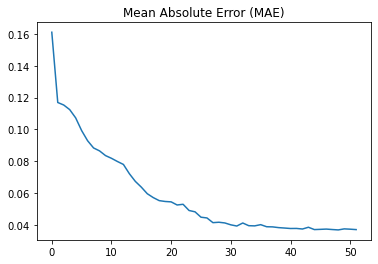

In [43]:
model_history = hist.history
loss = model_history['loss']
print(loss)



plt.figure()
plt.plot(loss, label='MAE')
plt.title('Mean Absolute Error (MAE)')
plt.show()

In [44]:
predictions = model.predict(x_test_seq)
predictions = scaler.inverse_transform(predictions)
y_test_original = scaler.inverse_transform(y_test_seq)
mae = np.mean(np.abs(predictions-y_test_original), axis=0)
for i, feature in enumerate(output_features):
    print("MAE untuk fitur ", feature, " : ", round(mae[i],3))
    if i == 3:
        break

16/16 [==============================] - 7s 24ms/step
MAE untuk fitur  Tn  :  0.041
MAE untuk fitur  Tx  :  0.057
MAE untuk fitur  RH_avg  :  0.566
MAE untuk fitur  RR  :  0.029


In [45]:
threshold_mae_Tn = (df['Tn'].max() - df['Tn'].min()) * 10 / 100
print("threshold_mae_Tn : ", threshold_mae_Tn)

threshold_mae_Tx = (df['Tx'].max() - df['Tx'].min()) * 10 / 100
print("threshold_mae_Tx : ", threshold_mae_Tx)

threshold_mae_RH_avg = (df['RH_avg'].max() - df['RH_avg'].min()) * 10 / 100
print("threshold_mae_RH_avg : ", threshold_mae_RH_avg)

threshold_mae_RR = (df['RR'].max() - df['RR'].min()) * 10 / 100
print("threshold_mae_RR : ", threshold_mae_RR)

threshold_mae_Tn :  0.5100000000000001
threshold_mae_Tx :  0.7
threshold_mae_RH_avg :  3.2
threshold_mae_RR :  0.4


<function matplotlib.pyplot.show(close=None, block=None)>

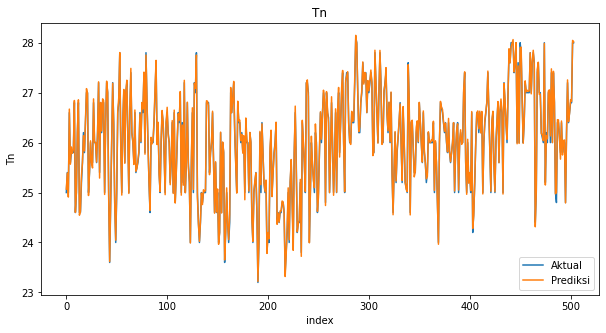

In [46]:
# Plot untuk Tn

target_index = 0 #Tn

plt.figure(figsize=(10,5))
plt.plot(y_test_original[:, target_index], label='Aktual')
plt.plot(predictions[:,target_index], label='Prediksi')
plt.xlabel('index')
plt.ylabel(output_features[target_index])
plt.title('Tn')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

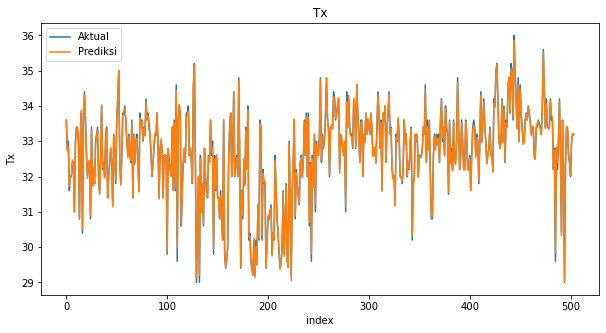

In [47]:
# Plot untuk Tx

target_index = 1 #Tx

plt.figure(figsize=(10,5))
plt.plot(y_test_original[:, target_index], label='Aktual')
plt.plot(predictions[:,target_index], label='Prediksi')
plt.xlabel('index')
plt.ylabel(output_features[target_index])
plt.title('Tx')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

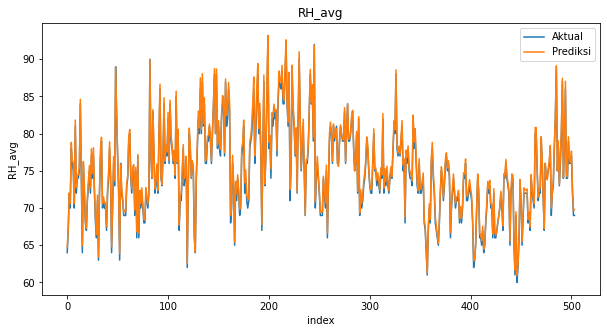

In [48]:
# Plot untuk RH_avg

target_index = 2 #RH_avg

plt.figure(figsize=(10,5))
plt.plot(y_test_original[:, target_index], label='Aktual')
plt.plot(predictions[:,target_index], label='Prediksi')
plt.xlabel('index')
plt.ylabel(output_features[target_index])
plt.title('RH_avg')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

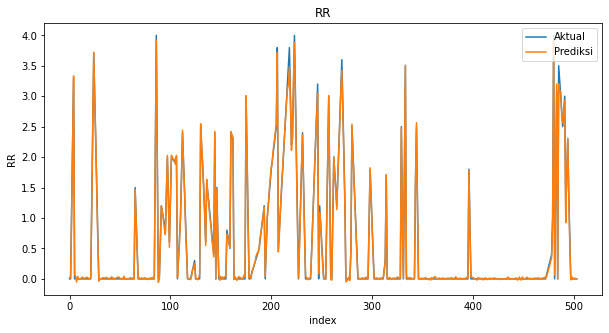

In [49]:
# Plot untuk RR

target_index = 3 #RR

plt.figure(figsize=(10,5))
plt.plot(y_test_original[:, target_index], label='Aktual')
plt.plot(predictions[:,target_index], label='Prediksi')
plt.xlabel('index')
plt.ylabel(output_features[target_index])
plt.title('RR')
plt.legend()
plt.show

In [50]:
# Ambil 24 waktu terakhir dari data Anda
last_24_timesteps = df[input_features].values[-timesteps:]

# Normalisasi menggunakan scaler
last_24_timesteps_scaled = scaler.transform(last_24_timesteps)

# Inisialisasi array untuk menyimpan hasil prediksi
future_predictions = []

# Lakukan prediksi untuk 30 waktu ke depan
for _ in range(30):
    # Reshape untuk sesuai dengan input model
    input_sequence = last_24_timesteps_scaled.reshape(1, timesteps, n_features_input)
    
    # Prediksi satu waktu ke depan
    prediction = model.predict(input_sequence)
    
    # Invers transformasi scaler untuk mendapatkan nilai dalam skala asli
    prediction_inversed = scaler.inverse_transform(prediction)
    
    # Tambahkan prediksi ke dalam array hasil
    future_predictions.append(prediction_inversed.flatten())
    
    # Update sekuens input untuk waktu berikutnya
    last_24_timesteps_scaled = np.concatenate((last_24_timesteps_scaled[1:], prediction), axis=0)

# Konversi hasil prediksi ke dalam DataFrame
future_predictions_df = pd.DataFrame(future_predictions, columns=output_features)

# Tampilkan hasil prediksi
print(future_predictions_df)

1/1 [==============================] - 0s 79ms/step
           Tn         Tx     RH_avg        RR   laju_Tn   laju_Tx  \
0   27.974813  33.164429  69.831093  0.009148 -0.415164  0.026024   
1   27.127569  33.211643  71.530136 -0.039016 -0.412549 -0.072886   
2   27.155313  32.997417  72.396561 -0.048453 -0.022863 -0.090621   
3   27.138800  33.038113  72.508575 -0.053292 -0.039871  0.043001   
4   27.147705  33.080910  72.526024 -0.060546 -0.075585  0.008217   
5   27.063583  33.050823  72.893959 -0.064619 -0.097291 -0.049921   
6   27.026470  32.983837  73.236763 -0.072274 -0.091699 -0.039742   
7   26.951063  32.975838  73.664810 -0.073066 -0.094817 -0.024224   
8   26.908989  32.939751  73.983704 -0.075591 -0.072030 -0.039093   
9   26.883585  32.905418  74.224602 -0.078744 -0.063662 -0.035783   
10  26.861006  32.877602  74.422905 -0.081618 -0.065781 -0.030495   
11  26.832588  32.854420  74.640495 -0.083206 -0.066006 -0.030707   
12  26.810009  32.826851  74.840378 -0.084496 -0.06

In [51]:
P_Tn = []
P_Tx = []
P_Tavg = []
P_RH_avg = []
P_RR = []
P_ss = []
for i in future_predictions_df['Tn']:
    P_Tn.append(round(np.abs(i),2))
for i in future_predictions_df['Tx']:
    P_Tx.append(round(np.abs(i),2))
for i in future_predictions_df['Tavg']:
    P_Tavg.append(round(np.abs(i),2))
for i in future_predictions_df['RH_avg']:
    P_RH_avg.append(round(np.abs(i),2))
for i in future_predictions_df['ss']:
    P_ss.append(round(np.abs(i),2))

KeyError: 'Tavg'

In [ ]:
print(P_Tn)

In [53]:
model.save("model_weather_4hari_jakarta.h5")